In [1]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
import os
import iris
import numpy as np
import seaborn as sns
from GridcellDataset import GridcellDataset
from pathos.multiprocessing import Pool
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

In [2]:
def plot_xr(xr, label=None, vmin=None, vmax=None):
    plt.close('all')
    fig = plt.figure(figsize=(18,1))

    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)

    im = ax1.pcolormesh(xr['target'], vmin=vmin, vmax=vmax)
    ax2.pcolormesh(xr['preds'], vmin=vmin, vmax=vmax)
    ax3.pcolormesh(xr['stratiform_rainfall_amount'], vmin=vmin, vmax=vmax)
    
    ax1.set_title('target')
    ax1.set_ylabel(label)
    ax2.set_title('model')
    ax3.set_title('baseline')

    fig.subplots_adjust(right=0.82)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax);

In [3]:
def plot(df, label=None, vmin=None, vmax=None):
    plt.close('all')
    fig = plt.figure(figsize=(18,1))

    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)

    im = ax1.pcolormesh(df['target'].unstack().values, vmin=vmin, vmax=vmax)
    ax2.pcolormesh(df['preds'].unstack().values, vmin=vmin, vmax=vmax)
    ax3.pcolormesh(df['stratiform_rainfall_amount'].unstack().values, vmin=vmin, vmax=vmax)
    
    ax1.set_title('target')
    ax1.set_ylabel(label)
    ax2.set_title('model')
    ax3.set_title('baseline')

    fig.subplots_adjust(right=0.82)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax);

In [4]:
def plot_means(df, label=None, vmin=None, vmax=None):
    means = df.groupby([pd.cut(df['lat'], np.arange(2, 3, 0.02)), 
                        pd.cut(df['lon'], np.arange(-5.1, 3.3, 0.02))]).mean()
    plot(means, label, vmin, vmax)

In [5]:
coord_system = iris.coord_systems.RotatedGeogCS(37.5, 177.5, 
                                                ellipsoid=iris.coord_systems.GeogCS(6371229.0)).as_cartopy_crs()

def transform(lon, lat):
    return coord_system.transform_point(lon, lat, ccrs.PlateCarree())

In [6]:
train_dfs = []
test_dfs = []
models = []
for i in [2,4,8]:
    train = pd.read_csv('../data/train{:d}.csv'.format(i))
    t = ['target', 'stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
         'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right'] 
    train[t] = np.log1p(train[t])
    
    rf = RandomForestRegressor(n_estimators=20, max_features='sqrt', n_jobs=1)
    X = train[train.columns.difference(['Unnamed: 0', 'target'])]
    y = train['target']
    rf.fit(X, y)
    
    test = pd.read_csv('../data/test{:d}.csv'.format(i))
    test[t[1:]] = np.log1p(test[t[1:]])
    Xt = test[test.columns.difference(['Unnamed: 0', 'target'])]
    yt = test['target']
    preds = rf.predict(Xt)
    test['preds'] = np.expm1(preds)
    test['stratiform_rainfall_amount'] = np.expm1(test['stratiform_rainfall_amount'])
    
    test['proj'] = test.apply(lambda x: transform(x['longitude'], x['latitude']), axis=1)
    test['lon'] = test.apply(lambda x: x['proj'][0], axis=1)
    test['lat'] = test.apply(lambda x: x['proj'][1], axis=1)
    
    train_dfs.append(train)
    test_dfs.append(test)
    models.append(rf)

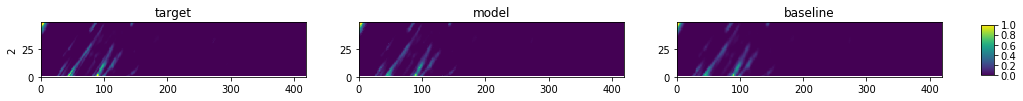

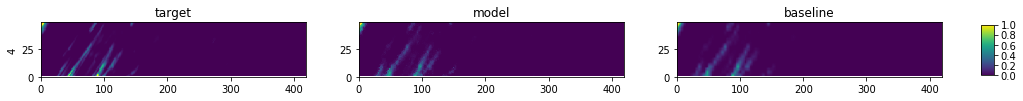

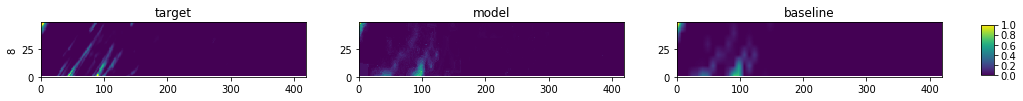

In [7]:
vmin = np.min(np.array([df[['target', 'preds', 'stratiform_rainfall_amount']].values for df in test_dfs]))
vmax = np.max(np.array([df[['target', 'preds', 'stratiform_rainfall_amount']].values for df in test_dfs]))

for i, test in enumerate(test_dfs):
    tstep = test[test['DOY'] == 173]
    means = tstep.groupby([pd.cut(tstep['lat'], np.arange(2, 3, 0.02)), 
                          pd.cut(tstep['lon'], np.arange(-5.1, 3.3, 0.02))]).mean()
    
    plot(means, vmin=0, vmax=1, label=str([2,4,8][i]))
    plt.show()

In [8]:
np.unique(test_dfs[0]['DOY'])

array([173, 203, 228, 231, 234])

In [9]:
cols = train_dfs[0].columns.difference(['Unnamed: 0', 'target'])

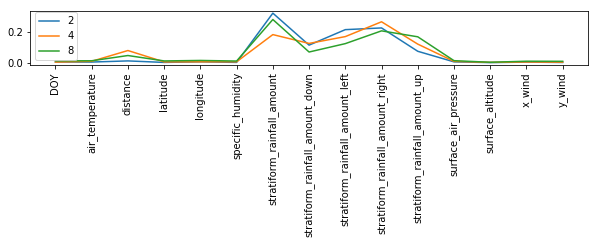

In [10]:
plt.figure(figsize=(10,1))
for i, m in enumerate(models):
    plt.plot(range(len(cols)), m.feature_importances_, label=str([2,4,8][i]))
    plt.gca().set_xticks(range(len(cols)))
    plt.gca().set_xticklabels(cols, rotation='vertical')
    plt.legend()

In [11]:
testset = test_dfs[0]

In [12]:
testset = testset[testset.columns.difference(['Unnamed: 0', 'target', 'proj', 'lat', 'lon', 'preds'])]

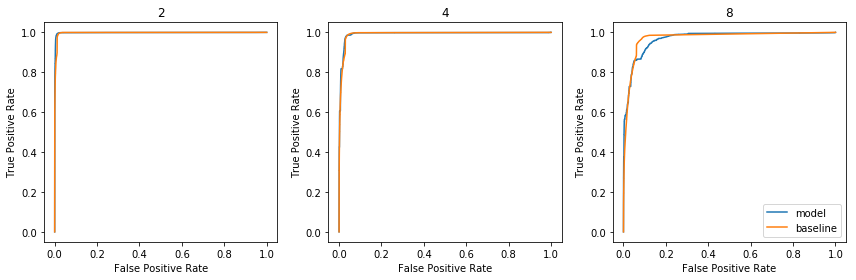

In [13]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, m in enumerate(models):
    yhat = m.predict(testset)
    true = (test_dfs[0]['target'] > 0).astype(int)
    fpr, tpr, _ = sklearn.metrics.roc_curve(true, yhat)
    ax[i].plot(fpr, tpr, label='model')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
for j, t in enumerate(test_dfs):
    yhat = t['stratiform_rainfall_amount']
    true = (t['target'] > 0).astype(int)
    fpr, tpr, _ = sklearn.metrics.roc_curve(true, yhat)
    ax[j].plot(fpr, tpr, label='baseline')
    ax[j].set_title([2,4,8][j])
    ax[j].set_xlabel('False Positive Rate')
    ax[j].set_ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()

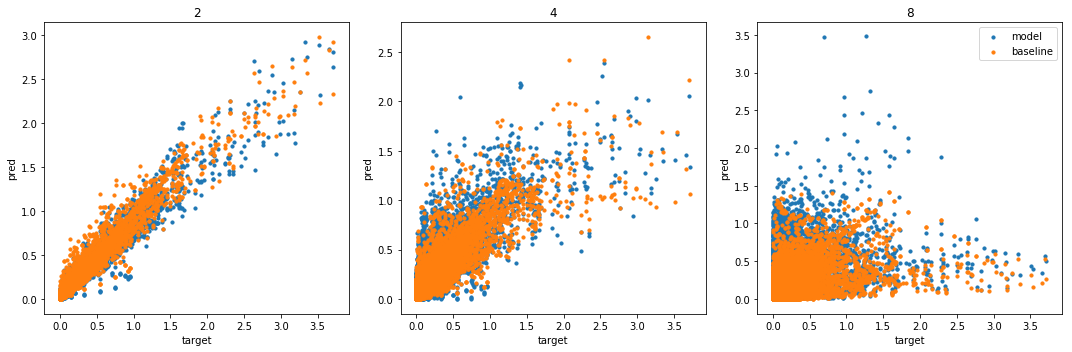

In [14]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, res in enumerate(test_dfs):
    yhat = res['preds']
    true = res['target']
    ax[i].scatter(true, yhat, s=10, label='model')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
# for i, res in enumerate(test_dfs):
    yhat = res['stratiform_rainfall_amount']
    true = res['target']
    ax[i].scatter(true, yhat, s=10, label='baseline')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
plt.legend()
plt.tight_layout()

In [10]:
def preds_vs_targets(res):
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    yhat = res['preds']
    true = res['target']
    ax[i].scatter(true, yhat, s=1, label='model')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
# for i, res in enumerate(test_dfs):
    yhat = res['stratiform_rainfall_amount']
    true = res['target']
    ax[i].scatter(true, yhat, s=1, label='baseline')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
    plt.legend()
    plt.tight_layout()

In [11]:
import xarray as xr

In [12]:
tdf = pd.read_csv('../data/id_test8.csv')
tdf = tdf[tdf['fcst_id'] > 0]

In [13]:
tx = xr.Dataset(tdf)

In [14]:
tx2 = tx.apply(lambda x: xr.DataArray(x.data.reshape((187, 48, 419)), dims=['time', 'y', 'x']))

In [15]:
proj = coord_system.transform_points(ccrs.PlateCarree(), 
                                     tx2['longitude'].data.flatten(), 
                                     tx2['latitude'].data.flatten()
                                    ).reshape(187, 48, 419, 3)[:,:,:,:2]
tx2['lon'] = (('time', 'y', 'x'), proj[:,:,:,0])
tx2['lat'] = (('time', 'y', 'x'), proj[:,:,:,1])

In [16]:
skip_vars = ['Unnamed: 0', 'Unnamed: 0.1', 'target', 'proj', 'lat', 'lon', 'fcst_id']
log_vars = ['stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
     'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right'] 

Xt = tx2[[k for k in tx2.data_vars.keys() if k not in skip_vars]]
for v in log_vars:
    Xt[v] = np.log1p(Xt[v])
preds = models[2].predict(Xt.to_array().data.reshape((15, -1)).T)
tx2['preds'] = (('time', 'y', 'x'), np.expm1(preds).reshape(187, 48, 419))

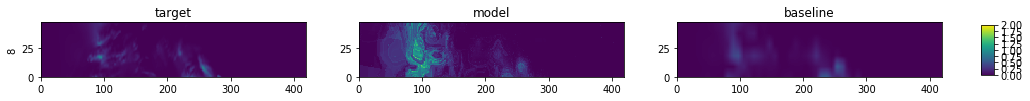

In [17]:
plot_xr(tx2.apply(lambda x: x[186]), vmin=0, vmax=2, label=str([2,4,8][i]))

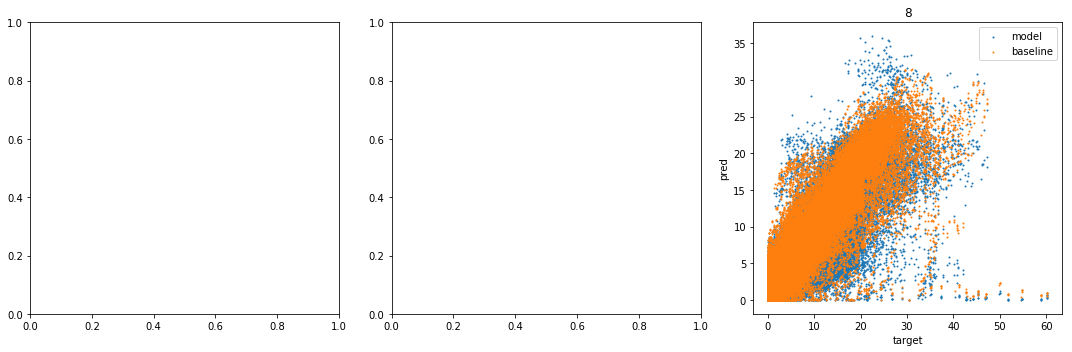

In [18]:
preds_vs_targets(tx2)

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import holoviews as hv
from datashader.bokeh_ext import InteractiveImage
from bokeh.plotting import figure, output_notebook, show
output_notebook()

/home/ubuntu/miniconda3/lib/python3.6/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


Loading BokehJS ...

In [31]:
def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.line(raw, 'X', 'Y', agg=ds.any())
    return tf.interpolate(agg)

NameError: name 'x_range' is not defined

In [50]:
tf.shade?

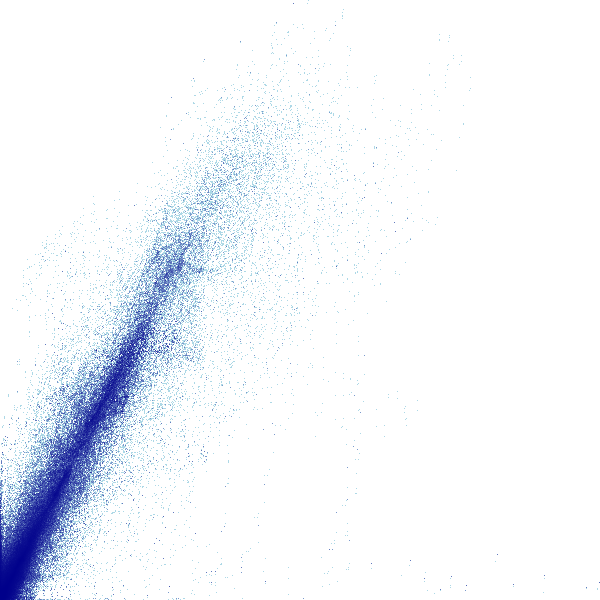

In [52]:
p = figure(
        x_range=(0, 20),
        y_range=(0, 40),
        tools='pan,wheel_zoom,box_zoom,reset', 
        plot_width=800, 
        plot_height=500,
    )
pipeline = ds.Pipeline(tx2[['target', 'preds']].to_dataframe(), ds.Point('target', 'preds'))
pipeline2 = ds.Pipeline(tx2[['target', 'stratiform_rainfall_amount']].to_dataframe(), 
                        ds.Point('target', 'stratiform_rainfall_amount'))
# p.scatter(x='target', y='preds', source=tx2[['target', 'preds']].to_dataframe())
# InteractiveImage(p, pipeline)
df = tx2[['target', 'preds', 'stratiform_rainfall_amount']].to_dataframe()
tf.shade(ds.Canvas().points(df,'target','preds'))
tf.shade(ds.Canvas().points(df,'target','stratiform_rainfall_amount'))

In [44]:
pipeline.agg

In [44]:
t = ['stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
     'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right'] 

test2 = pd.read_csv('../data/id_test8.csv')
test2 = test2[test2['fcst_id'] > 170]
test2['proj'] = test2.apply(lambda x: transform(x['longitude'], x['latitude']), axis=1)
test2['lon'] = test2.apply(lambda x: x['proj'][0], axis=1)
test2['lat'] = test2.apply(lambda x: x['proj'][1], axis=1)
test2[t] = np.log1p(test2[t])
Xt = test2[test2.columns.difference(['Unnamed: 0', 'Unnamed: 0.1', 'target', 'proj', 'lat', 'lon', 'fcst_id'])]
preds = models[2].predict(Xt)
test2['preds'] = np.expm1(preds)
test2['stratiform_rainfall_amount'] = np.expm1(test2['stratiform_rainfall_amount'])

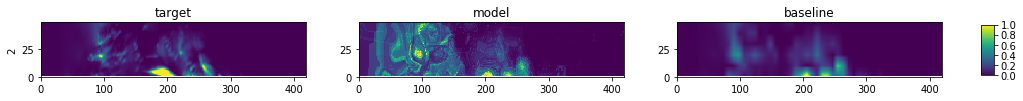

In [47]:
# plot(test2[test2['fcst_id'] == 170])
plot_means(test2[test2['fcst_id'] == 186], vmin=0, vmax=1, label=str(2))

In [113]:
# %%time
# trainset = train_dfs[0].copy()

# trainset['proj'] = trainset.apply(lambda x: transform(x['longitude'], x['latitude']), axis=1)
# trainset['lon'] = trainset.apply(lambda x: x['proj'][0], axis=1)
# trainset['lat'] = trainset.apply(lambda x: x['proj'][1], axis=1)

In [114]:
# means = trainset.groupby([pd.cut(trainset['lat'], np.arange(2, 3, 0.02)), 
#                           pd.cut(trainset['lon'], np.arange(-5.1, 3.3, 0.02))]).max()

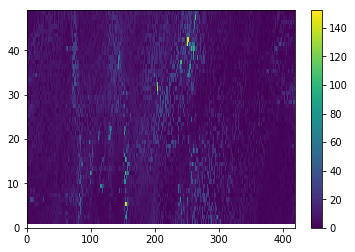

In [10]:
plt.pcolormesh(means['target'].unstack().values)
plt.colorbar()

(0, 1000)

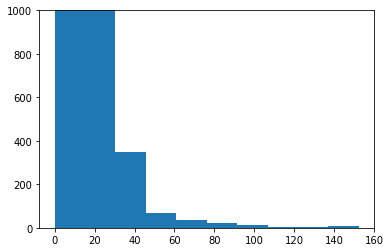

In [109]:
plt.hist(train_dfs[0]['target'])
plt.gca().set_ylim((0,1000))